In [1]:
# Loading the packages

import os
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

from keras.optimizers import SGD
from keras.models import Sequential
from keras.layers.core import Dense, Flatten, Activation, Dropout
from keras.layers.convolutional import Conv2D, MaxPooling2D, AveragePooling2D

In [2]:
# Loading the data

train = pd.read_csv('data/dataset/sign_mnist_train.csv')
test = pd.read_csv('data/dataset/sign_mnist_test.csv')

print(f'We have {train.shape[0]} training examples and {test.shape[0]} test examples')
train.head(3)

We have 27455 training examples and 7172 test examples


,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195


## Preprocessing and visualization

In [3]:
# Data splitting creating square np.arrays

training_images = train.iloc[:,1:].values
training_labels = train.iloc[:,0].values
testing_images = test.iloc[:,1:].values
testing_labels = test.iloc[:,0].values

training_images_square = training_images.reshape(-1,28,28,1)
testing_images_square = testing_images.reshape(-1,28,28,1)

Text(0.5, 1.0, 'Testing labels class count')

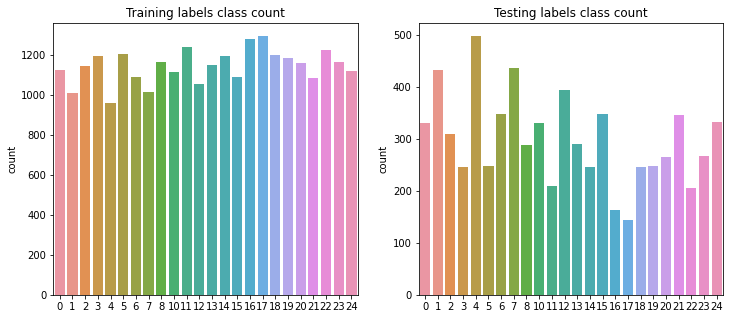

In [4]:
# Plot target count

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12,5)) 
sns.countplot(x=training_labels,ax=ax1)
ax1.set_title('Training labels class count')
sns.countplot(x=testing_labels,ax=ax2)
ax2.set_title('Testing labels class count')

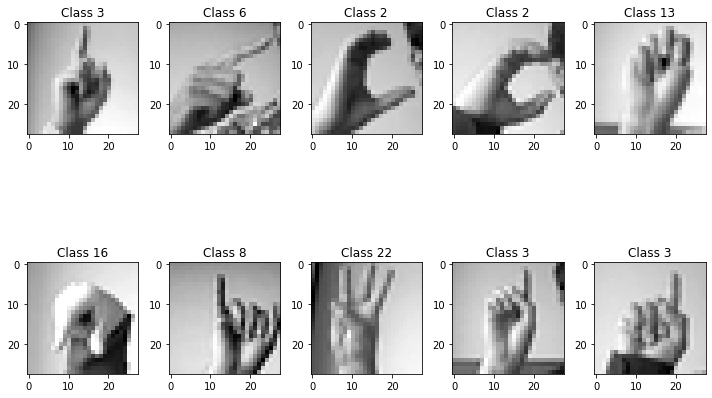

In [5]:
# Plot the first 10 images 

fig, ax = plt.subplots(2,5) 
fig.set_size_inches(10, 10)
k = 0
for i in range(2):
    for j in range(5):
        ax[i,j].imshow(training_images[k].reshape(28, 28), cmap = "gray")
        ax[i,j].set_title(f'Class {training_labels[k]}')
        k += 1
    plt.tight_layout()

In [6]:
# Normalize images and encode labels

X_train = training_images_square.astype("float32") / 255.0
X_test = testing_images_square.astype("float32") / 255.0

y_train = to_categorical(training_labels)
y_test = to_categorical(testing_labels)

In [7]:
# Look at preprocessed data shapes

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (27455, 28, 28, 1)
X_test shape: (7172, 28, 28, 1)
y_train shape: (27455, 25)
y_test shape: (7172, 25)


## Convolutional neural network

In [8]:
# create CNN LeNet model class with max and avg pooling

class LeNet():
    @staticmethod
    def build(numChannels, imgRows, imgCols, numClasses,  pooling= "max", activation= "relu"):
        
        model = Sequential()
        inputShape = (imgRows, imgCols, numChannels)

        # Layer 1: Conv -> Activation -> Pool
        model.add(Conv2D(filters= 6, kernel_size= 5, input_shape= inputShape))
        model.add(Activation(activation))
        if pooling == "max":
            model.add(MaxPooling2D(pool_size= (2, 2), strides= (2, 2)))
        else:
            model.add(AveragePooling2D(pool_size= (2, 2), strides= (2, 2)))

        # Layer 2: Conv -> Activation -> Pool
        model.add(Conv2D(filters= 16, kernel_size= 5))
        model.add(Activation(activation))
        if pooling == "avg":
            model.add(AveragePooling2D(pool_size=(2, 2), strides=(2, 2)))
        else:
            model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

        # Layer 3: Fully connected 120 -> Dropout -> Activation
        model.add(Flatten())
        model.add(Dense(120))
        model.add(Dropout(0.02))
        model.add(Activation(activation))

        # Layer 4: Fully connected 84 -> Dropout -> Activation
        model.add(Dense(84))
        model.add(Dropout(0.02))
        model.add(Activation(activation))

        # Layer 5: Fully connected 25 -> Softmax
        model.add(Dense(numClasses))
        model.add(Activation("softmax"))

        return model

In [9]:
# Model and structure hyperparameters

IMG_SIZE = 28
NUM_CLASSES = 25 # target values
opt = SGD(lr=0.01) # stochastic gd

In [10]:
# First model with max pooling
model = LeNet.build(1, IMG_SIZE, IMG_SIZE, NUM_CLASSES, pooling= "max")
model.compile(loss= "categorical_crossentropy", optimizer= opt, metrics= ["accuracy"])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 24, 24, 6)         156       
_________________________________________________________________
activation (Activation)      (None, 24, 24, 6)         0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 6)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 16)          2416      
_________________________________________________________________
activation_1 (Activation)    (None, 8, 8, 16)          0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 4, 16)          0         
_________________________________________________________________
flatten (Flatten)            (None, 256)               0

In [11]:
# Training hyperparameters

BS = 100
EPOCHS = 80

In [12]:
# Train model
LeNet_ = model.fit(X_train, y_train, validation_split = 0.2, batch_size= BS,
              epochs= EPOCHS, verbose=0)

# Evaluate the train and test data
scores_train = model.evaluate(X_train, y_train, verbose= 1)
scores_test = model.evaluate(X_test, y_test, verbose= 1)
print(f'Model with Max Pool Accuracy on Train Data: {scores_train[1]*100}')
print(f'Model with Max Pool Accuracy on Validation Data: {scores_test[1]*100}')

225/225 [==============================] - 1s 6ms/step - loss: 0.4479 - accuracy: 0.8922
Model with Max Pool Accuracy on Train Data: 100.0
Model with Max Pool Accuracy on Validation Data: 89.22197222709656


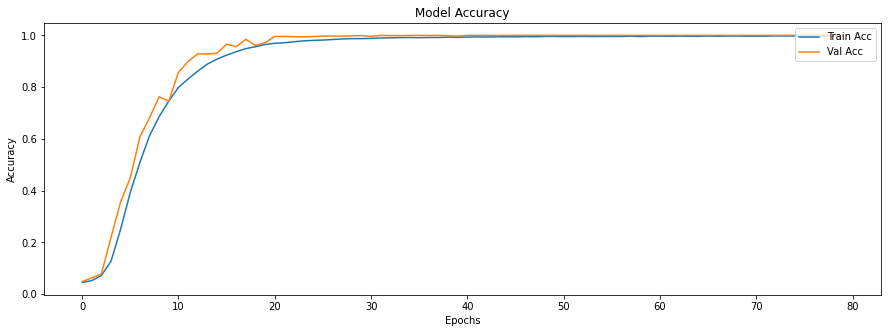

In [13]:
# Plot accuracy over epochs

plt.figure(figsize=(15,5))
plt.plot(np.arange(0, EPOCHS), LeNet_.history["accuracy"], label="Train Acc")
plt.plot(np.arange(0, EPOCHS), LeNet_.history["val_accuracy"], label="Val Acc")
plt.title("Model Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(loc="upper right")

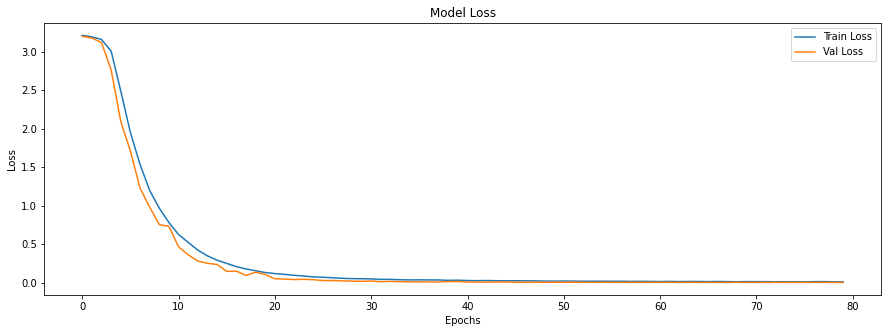

In [14]:
# Plot loss over epochs

plt.figure(figsize=(15,5))
plt.plot(np.arange(0, EPOCHS), LeNet_.history["loss"], label="Train Loss")
plt.plot(np.arange(0, EPOCHS), LeNet_.history["val_loss"], label="Val Loss")
plt.title("Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(loc="upper right")

In [15]:
# Accuracy on test with all train data

from sklearn.metrics import accuracy_score

model.fit(X_train, y_train, batch_size= BS, epochs= EPOCHS, verbose=0)
accuracy_score(y_test.argmax(1), model.predict(X_test).argmax(1))

0.9008644729503625

## Plot CNN layers

In [16]:
from keras.models import Model

layer_outputs = [layer.output for layer in model.layers]
activation_model = Model(inputs=model.input, outputs=layer_outputs)
activations = activation_model.predict(X_train[1].reshape(1,28,28,1))
 
def display_activation(activations, col_size, row_size, act_index, title): 
    activation = activations[act_index]
    activation_index = 0
    fig, ax = plt.subplots(row_size, col_size, figsize=(12,8))
    fig.suptitle(title)
    for row in range(0,row_size):
        for col in range(0,col_size):
            ax[row][col].imshow(activation[0, :, :, activation_index], cmap='gray')
            activation_index += 1

In [17]:
layer_outputs

[<KerasTensor: shape=(None, 24, 24, 6) dtype=float32 (created by layer 'conv2d')>,
 <KerasTensor: shape=(None, 24, 24, 6) dtype=float32 (created by layer 'activation')>,
 <KerasTensor: shape=(None, 12, 12, 6) dtype=float32 (created by layer 'max_pooling2d')>,
 <KerasTensor: shape=(None, 8, 8, 16) dtype=float32 (created by layer 'conv2d_1')>,
 <KerasTensor: shape=(None, 8, 8, 16) dtype=float32 (created by layer 'activation_1')>,
 <KerasTensor: shape=(None, 4, 4, 16) dtype=float32 (created by layer 'max_pooling2d_1')>,
 <KerasTensor: shape=(None, 256) dtype=float32 (created by layer 'flatten')>,
 <KerasTensor: shape=(None, 120) dtype=float32 (created by layer 'dense')>,
 <KerasTensor: shape=(None, 120) dtype=float32 (created by layer 'dropout')>,
 <KerasTensor: shape=(None, 120) dtype=float32 (created by layer 'activation_2')>,
 <KerasTensor: shape=(None, 84) dtype=float32 (created by layer 'dense_1')>,
 <KerasTensor: shape=(None, 84) dtype=float32 (created by layer 'dropout_1')>,
 <Kera

Text(0.5, 1.0, 'Input data')

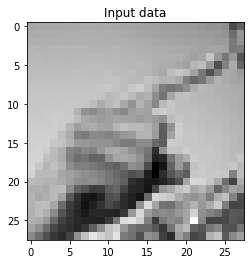

In [18]:
plt.imshow(X_train[1].reshape(28,28,1), cmap='gray')
plt.title('Input data')

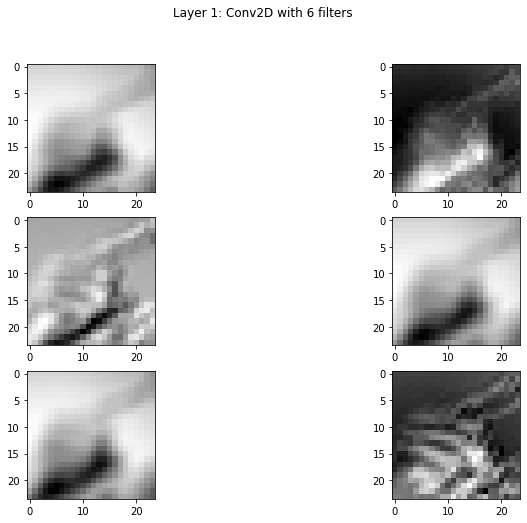

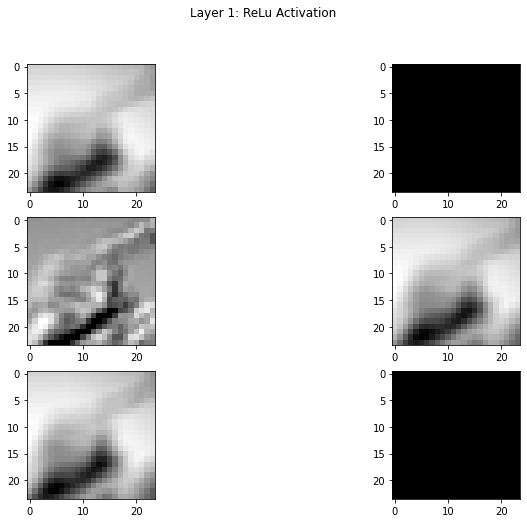

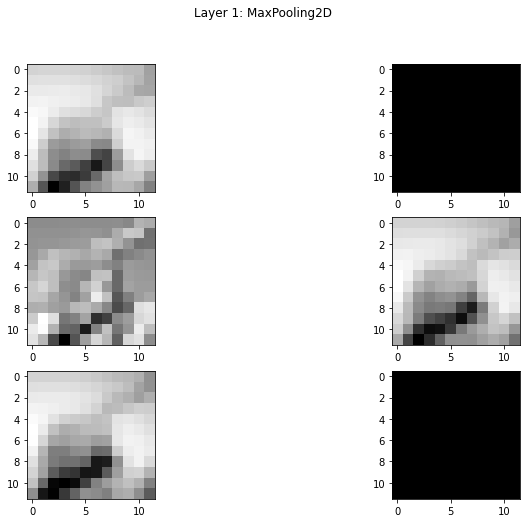

In [19]:
# Layer 1: Conv -> Activation -> Pool

display_activation(activations, 2, 3, 0, title = 'Layer 1: Conv2D with 6 filters')
display_activation(activations, 2, 3, 1, title = 'Layer 1: ReLu Activation')
display_activation(activations, 2, 3, 2, title = 'Layer 1: MaxPooling2D')

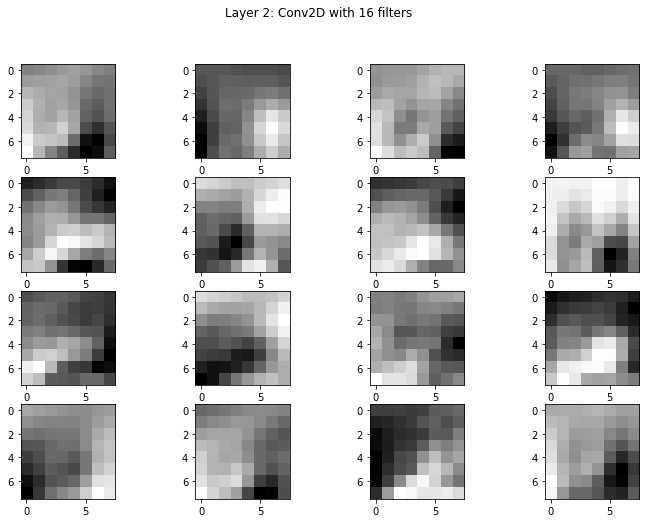

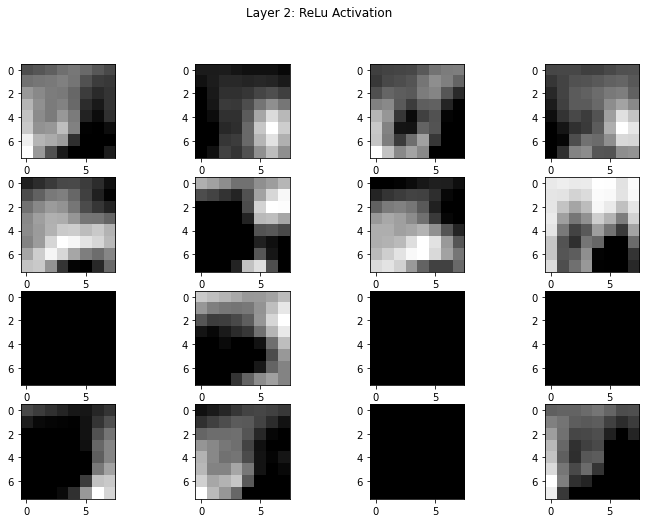

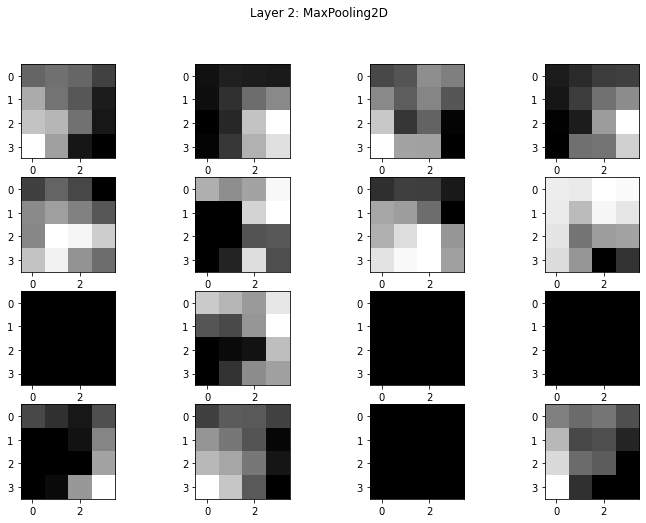

In [20]:
# Layer 2: Conv -> Activation -> Pool

display_activation(activations, 4, 4, 3, title = 'Layer 2: Conv2D with 16 filters')
display_activation(activations, 4, 4, 4, title = 'Layer 2: ReLu Activation')
display_activation(activations, 4, 4, 5, title = 'Layer 2: MaxPooling2D')